# Policy Gradient methods vs Value-function methods

Last week, we learned about **Policy Gradient methods**. In comparison with conventional "Q-value-based" methods, policy gradient ones are **end-to-end** in the sense that they **directly** optimize $\pi(a,s,\theta)$ instead of defining $\pi(s,a)$ to be greedy with respect to a learned $Q(s,a)$ approximation. Consequently, policy gradient methods allow the agent to behave according to a **stochastic policy**, while Q-value methods are typically following a deterministic policy at exploitation time (the one which is greedy with respect to $Q(s,a)$).

<img style="float: left;" src="imgs/approaches.png", width=600>

In the following, I consider two grid-world tasks on which I compare both approaches:
    
+ *(small experiment)* The **Short corridor with switched actions** example (see Example 13.1 in Sutton's book). For this experiment, features are one-hot vectors so the situation is equivalent to the **tabular case**, and all algorithms I tried are using **full returns** (MC methods). In particular, the policy gradient methods considered here are **REINFORCE**, **REINFORCE-with-baseline**.


+ *(bigger experiment)* A **Deep Q-Net vs Deep Policy-Net contest** on another gridworld environment (but with a bigger statespace). In this experiment, both approaches are optimizing $\theta$ using **one-step returns** (bootstraping). The policy gradient algorithm is therefore **One-step Actor-Critic**. 

In both experiments, my results illustrates that **policy gradient approaches outperforms Q-value ones** on these tasks.

### Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1) Short corridor with switched actions

This gridworld example has been especially designed to illustrate that **stochastic policies are sometimes better than deterministic ones**. In fact, if the agent follows a deterministic policy, he will never reach the terminal state and will 

See Example 13.1 in the book:

*"Consider the short corridor gridworld shown inset in Figure 13.1. The reward
is -1 per step as usual. In each of the three nonterminal states there are only
two actions, right and left. The actions have their usual consequences in the first
and third states, but in the second state they are reversed, so that right moves
to the left and left moves to the right. The problem is dificult because all the
states appear identical under the function approximation. In particular, we
define $\Phi(s, right) = [1, 0]^T$ and $\Phi(s, left) = [0, 1]^T$, for all s."*

(chapter 13, page 267) 

<img style="float: left;" src="imgs/corridor_1.png", width=400>

Ideally, in order to reach the goal as fast as possible, the agent would have to take the successive set of actions : "right" $\rightarrow$ "left" $\rightarrow$ "right"

<img style="float: left;" src="imgs/corridor_2.png", width=225>

As explained above, the agent is "blind": features don't depend on the current position so the agent doesn't know if he is in the "switched action" state or not. Consequently, a deterministic agent based on value-function is doomed to choose between the *left* or the *right* action and he will loop for ever between the first cell and the second cell. If the agent follows an $\epsilon$-greedy policy (which is typically the case for value-function methods, at least during training), the agent has a small probability of reaching the terminal state:

$$Pr(right \rightarrow left \rightarrow right) = (1-\epsilon/2)^2 \ \epsilon/2$$

For instance, when $\epsilon = 0.1$, this is equal to $ \approx 0.045$. One could manage to obtain decent results by fine-tuning the hyperparameter $\epsilon$. But of course, a better strategy consists in learning $\epsilon$, i.e. using a policy gradient method that is able to learn the optimal stochastic policy.

#### Environment code

In [388]:
class corridor():
    def __init__(self, ncells):
        self.s = 0
        self.ncells = ncells
        
    def reset(self):
        self.s = 0
        
    def iterate(self, a):
        if self.is_terminate():
            return 0
        if a == "left":
            self.s -= (1 - int(self.s == 0))*(2*int(self.s != self.ncells/2) - 1)
        else:
            self.s += 1*(2*int(self.s != self.ncells/2) - 1)
        return (-1.)*float(2*(self.s<self.ncells)-1)
    
    def is_terminate(self):
        return self.s >= self.ncells
    
    def demo(self, a):
        s = self.s
        r = self.iterate(a)
        sprime = self.s
        print("State %d, Action %s ---> State %d (R=%.1f)"%(s, a, sprime, r))

In [3]:
corr = corridor(3)
corr.demo("right")

State 0, Action right ---> State 1 (R=-1.0)


#### Utils functions

In [397]:
def one_hot(idx, length):
    if np.ndim(idx) == 0:
        idx = np.array([idx])
    out = np.zeros((length, 1), "float32")
    out[idx, 0] = 1
    return out

def epsilon_greedy(q, epsilon):
    if np.random.rand()>epsilon:
        A = np.argmax(q)
    else:
        A = np.random.randint(0, q.shape[0])
    return A

def sample_from_pi(pi):
    return int(np.random.rand()>pi[0])

def softmax(theta):
    E = np.exp(theta - theta.max())
    return E/E.sum()

def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

#### Training code

In [389]:
def train(mode, corridor, alpha=0.001,  iterations=1000, gamma=0.95, epsilon=0.1, string_actions=["left", "right"]):
    
    assert mode in ["q", "reinforce", "reinforce-baseline"]
    
    w = np.zeros(len(string_actions))       # value-function weights
    theta = np.zeros(len(string_actions))   # policy weights
    pi = softmax(theta)
    history_w = []
    history_pi = []
    history_cumul_rewards = []
    
    for episode in range(iterations):
        corridor.reset()
        rewards = []
        discounts = []
        actions = []
        
        count = 0
        while not corridor.is_terminate() and count<1000:
            if mode == "q":
                A = epsilon_greedy(theta, epsilon)
            else:
                A = sample_from_pi(pi)
            str_A = string_actions[A]
            R = corridor.iterate(str_A)
            actions.append(A)
            rewards.append(R)
            discounts.append(gamma**count)
            count += 1
            
        actions = np.array(actions)
        rewards = np.array(rewards)[::-1]
        discounts = np.array(discounts)[::-1]
        
        for t in range(count):
            Gt = np.sum(rewards[0:count-t]*discounts[t:])
            w[actions[t]] += alpha*(Gt - w[actions[t]]) 
            if mode != "q":
                deltaLog = one_hot(actions[t], len(string_actions)).flatten() - pi
                if mode == "reinforce":
                    theta += alpha*(gamma**t)*Gt*deltaLog
                else:
                    theta += alpha*(gamma**t)*(Gt-w[actions[t]])*deltaLog
            pi = softmax(theta)
            
        history_w.append(np.copy(w))
        history_pi.append(np.copy(pi))
        history_cumul_rewards.append(np.sum(rewards))
            
    return theta, np.array(history_w), np.array(history_pi), np.array(history_cumul_rewards)

### 1) a) Value-function method - $\epsilon$-greedy wrt $Q(s,a)$

Using the full return $G_t$ as the target:

$$ w_{t+1} = w_{t} + \alpha \ (G_t - q_{w_{t}}(s,a)) \ \nabla q_{w_{t}}(s,a)$$

In [407]:
theta, hw, hpi, hr = train("q", corr, alpha=0.0001, iterations=10000, epsilon=0.1)

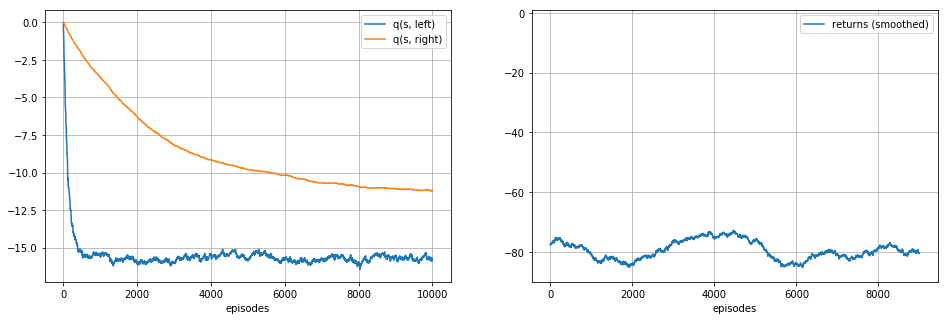

Mean return : -79.4052


In [409]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(moving_average(hw[:,0], 1), label="q(s, left)")
plt.plot(moving_average(hw[:,1], 1), label="q(s, right)")
plt.xlabel("episodes")
plt.grid()
plt.legend()
plt.subplot(1,2,2)
plt.plot(moving_average(hr, 1000), label="returns (smoothed)")
plt.grid()
plt.xlabel("episodes")
plt.ylim([-90, 1])
plt.legend()
plt.show()

print "Mean return :", np.mean(hr)

### 1) b) REINFORCE - stochastic policy

In [418]:
theta, hw, hpi, hr = train("reinforce", corr, alpha=0.0001, iterations=20000, epsilon=0.1)

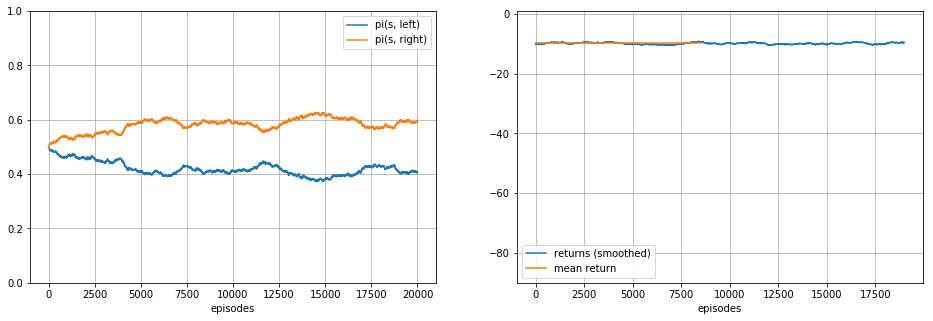

Pi : [ 0.40622863  0.59377137]
Mean return : -9.8534


In [419]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(moving_average(hpi[:,0], 1), label="pi(s, left)")
plt.plot(moving_average(hpi[:,1], 1), label="pi(s, right)")
plt.xlabel("episodes")
plt.grid()
plt.ylim([0, 1])
plt.legend()
plt.subplot(1,2,2)
plt.plot(moving_average(hr, 1000), label="returns (smoothed)")
plt.plot([0,8500], [np.mean(hr), np.mean(hr)], label="mean return")
plt.grid()
plt.xlabel("episodes")
plt.ylim([-90, 1])
plt.legend()
plt.show()

print "Pi :", hpi[-1]
print "Mean return :", np.mean(hr)

### 1) c) REINFORCE-with-baseline - stochastic policy

Adding a baseline = Reduction variance technique.

Here, the baseline is an approximate Q-value function:

$$ \theta_{t+1} = \theta_{t} + \alpha \ (G_t - q_{w_{t+1}}(s,a)) \ \nabla_{\theta} \log \pi_{\theta}(s,a)$$

and additional parameters needs to be learned to approximate Q:

$$ w_{t+1} = w_{t} + \alpha \ (G_t - q_{w_{t}}(s,a)) \ \nabla q_{w_{t}}(s,a)$$

In [420]:
theta, hw, hpi, hr = train("reinforce-baseline", corr, alpha=0.0001, iterations=20000)

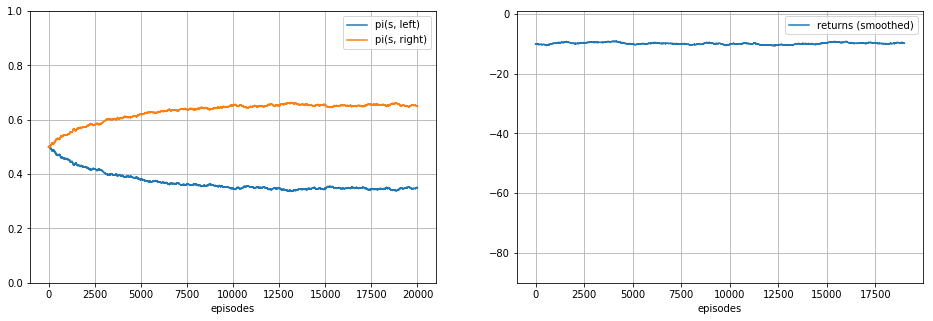

Pi : [ 0.3503795  0.6496205]
Mean return : -9.87085


In [422]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(moving_average(hpi[:,0], 1), label="pi(s, left)")
plt.plot(moving_average(hpi[:,1], 1), label="pi(s, right)")
plt.xlabel("episodes")
plt.grid()
plt.ylim([0, 1])
plt.legend()
plt.subplot(1,2,2)
plt.plot(moving_average(hr, 1000), label="returns (smoothed)")
plt.grid()
plt.xlabel("episodes")
plt.ylim([-90, 1])
plt.legend()
plt.show()

print "Pi :", hpi[-1]
print "Mean return :", np.mean(hr)

As expected, adding a baseline seems to make training more stable.

In [424]:
0.6*0.6*0.4

0.144

In [423]:
0.65*0.65*0.35

0.147875

As a conclusion, this toy example illustrates that stochastic policies can outperform deterministic ones. The next experiment will confirm this.

# 2) Deep Q-Net (DQN) vs Deep Policy-Net (DPN = actor-critic method)

In order to compare DQN and DPN, I re-used my code of assignment 2 (DQN implementation), and I did my experiments on the same gridworld task I experimented in assignment 4:

In [18]:
import dqn
import deepnets
import utils

In [425]:
environment_demo = dqn.demo_GridWorld()

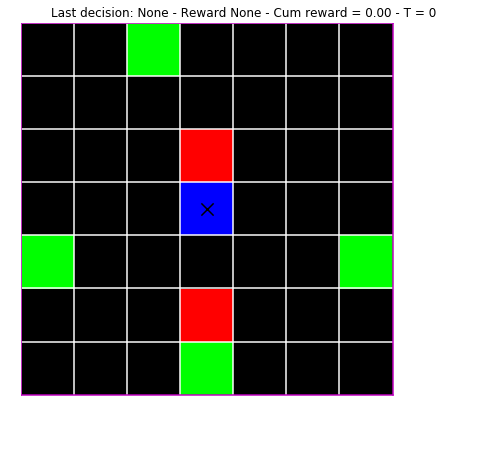

In [434]:
s = next(environment_demo)

**Rules:** the agent (blue) evolves in a Gridworld. When the agent moves on a green cell, the reward is +0.5. On the contrary, when the agent moves on a red cell, the reward is -1.0. For any other move, the reward is -0.1. When a green cell is reached, it re-appear elsewhere.

Inspired from https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-6-partial-observability-and-deep-recurrent-q-68463e9aeefc

### Neural Net architectures

<img style="float: left;" src="imgs/architectures.png", width=800>

#### Some params

In [ ]:
epsilon = 0.8
gamma= 0.99
batch_size = 32
target_patience = 1
buffer_size = 20*batch_size

### DQN training

Using a target network and an experience buffer...

In [16]:
# Environment
environment = dqn.GridWorld(7, 7, 5, 3, 50, gamma=gamma, centered=True)
# A neural net
neuralnet = deepnets.DQN_7x7((3, 7, 7), 0.01, adam=True)
targetnet = deepnets.DQN_7x7((3, 7, 7), 0.01, adam=True)
# ExperienceReplay 
experience_replay = dqn.ExperienceReplay(environment.return_state().shape, buffer_size)
# Agent
agent = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)

#### Training

In [ ]:
Qsize = 10
name = "DQN"
# Train for 100 epochs of 1500 updates
agent.fit(3000, 100, max_q_size=Qsize, savename="experiments/weights_%s.npy"%name)
# Save learning curve
agent.save_curve("experiments/curve_%s.npy"%name)

### DPN training

In [ ]:
# Environment
environment = dqn.GridWorld(7, 7, 5, 3, 50, gamma=gamma, centered=True)
# A neural net
neuralnet = deepnets.DPN_7x7((3, 7, 7), 0.001,  adam=True)
# ExperienceReplay 
experience_replay = dqn.ExperienceReplay(environment.return_state().shape, buffer_size)
# Agent
agent = dqn.DPNAgent(environment, neuralnet, experience_replay, batch_size, epsilon=epsilon, gamma=gamma)

#### Training

In [ ]:
Qsize = 10
name = "DPN"
# Train for 100 epochs of 1500 updates
agent.fit(3000, 100, max_q_size=Qsize, savename="experiments/weights_%s.npy"%name)
# Save learning curve
agent.save_curve("experiments/curve_%s.npy"%name)

### DPN with a shared network for the actor and the critic

In [ ]:
# Environment
environment = dqn.GridWorld(7, 7, 5, 3, 50, gamma=gamma, centered=True)
# A neural net
neuralnet = deepnets.DPN_7x7_shared((3, 7, 7), 0.001,  adam=True)
# ExperienceReplay 
experience_replay = dqn.ExperienceReplay(environment.return_state().shape, buffer_size)
# Agent
agent = dqn.DPNAgent(environment, neuralnet, experience_replay, batch_size, epsilon=epsilon, gamma=gamma)

#### Training

In [ ]:
Qsize = 10
name = "DPN_shared"
# Train for 100 epochs of 1500 updates
agent.fit(3000, 100, max_q_size=Qsize, savename="experiments/weights_%s.npy"%name)
# Save learning curve
agent.save_curve("experiments/curve_%s.npy"%name)

#### Learning curve

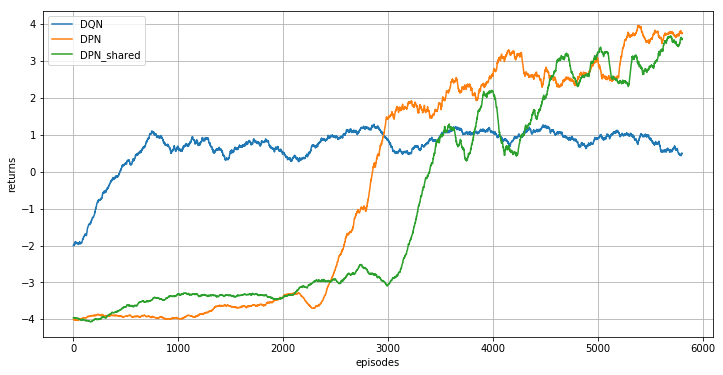

In [436]:
plt.figure(figsize=(12,6))
for name in ["DQN", "DPN", "DPN_shared"]: #, "DRQN"]:
    curve = np.load("experiments/curve_%s.npy"%name)
    plt.plot(utils.moving_average(curve, 200), label=name)
plt.grid()
plt.legend()
plt.ylabel("returns")
plt.xlabel("episodes")
plt.show()

##### add comments

## Demo

In [440]:
# Environment
environment = dqn.GridWorld(7, 7, 5, 3, 50, gamma=gamma, centered=True)
# A neural net
neuralnet = deepnets.DQN_7x7((3, 7, 7), 0.01, adam=True)
targetnet = deepnets.DQN_7x7((3, 7, 7), 0.01, adam=True)
# ExperienceReplay 
experience_replay = dqn.ExperienceReplay(environment.return_state().shape, buffer_size)
# Agent
DQN = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)
# Load weights
DQN.load_weights("experiments/weights_DQN.npy")

# Environment
p_environment = dqn.GridWorld(7, 7, 5, 3, 50, gamma=gamma, centered=True)
# A neural net
p_neuralnet = deepnets.DPN_7x7((3, 7, 7), 0.001,  adam=True)
# ExperienceReplay 
p_experience_replay = dqn.ExperienceReplay(environment.return_state().shape, buffer_size)
# Agent
DPN = dqn.DPNAgent(p_environment, p_neuralnet, p_experience_replay, batch_size, epsilon=epsilon, gamma=gamma)
# Load weights
DPN.load_weights("experiments/weights_DPN.npy")

Left: DQN 							Right: DPN


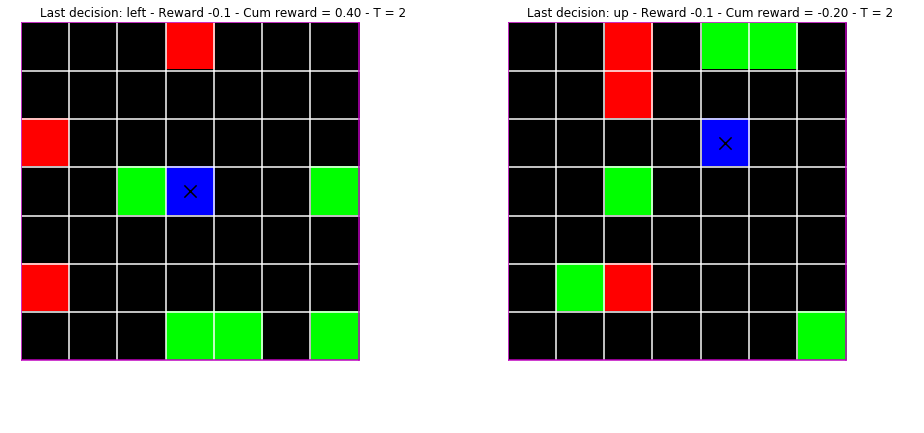

In [492]:
DQN.epsilon = 1.

print("Left: DQN \t\t\t\t\t\t\tRight: DPN")
plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
batch, target_batch =  DQN.demo(fig=False)
plt.subplot(1,2,2)
batch, target_batch =  DPN.demo(fig=False)
plt.show()